In Lab (1), we develop a simplified training pipeline. To obtain better training result, we will improve the
training pipeline by employing data augmentation, improving the model design, and tuning the hyperpa-
rameters.


In [22]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

# Lab 3 Part A
The improved training pipeline for SimpleNN developed in Lab (2) still has limited performance. This
is mainly because the SimpleNN has a rather small capacity (learning capability) for the CIFAR-10 task.
Thus, in this lab, we replace the SimpleNN model with a more advanced ResNet [3] architecture. We
expect to see much higher accuracy on CIFAR-10 when using ResNets. 

In [30]:
class Residual_Block(nn.Module):
    def __init__(self, input, output, stride, downsample):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.downsample = downsample

    def forward(self, x):
        x0 = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample is not None:
            x0 = self.downsample(x0)
        output += x0
        output = F.relu(output)
        return output

In [31]:
class ResNet20(nn.Module):
    def __init__(self, ):
        super(ResNet20, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.Residual_Layer(input=64, output=64, stride=1)   # only the first layer's has stride=1 -- no downsample
        self.layer2 = self.Residual_Layer(input=64, output=128, stride=2)
        self.layer3 = self.Residual_Layer(input=128, output=256, stride=2)
        self.layer4 = self.Residual_Layer(input=256, output=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 10)


    def Residual_Layer(self, input, output, stride):
        if stride == 2:
            downsample = nn.Sequential(
                nn.Conv2d(input, output, kernel_size=1, stride=2, padding=0),
                nn.BatchNorm2d(output)
            )
        else:
            downsample = None
        layer = nn.Sequential(
            Residual_Block(input, output, stride, downsample),
            Residual_Block(output, output, 1, None)
        )
        return layer

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        # output = self.maxpool(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output
# initialize the model
model = ResNet20()

# specify the device for computation
#############################################
# check the device 
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    print("Model deployed on GPU.")
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("Model deployed on CPU.")

#############################################

summary(model, input_size=(3,32,32))

Model deployed on GPU.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
    Residual_Block-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
   Residual_Block-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2

## Step 1: Set up preprocessing functions

In [32]:
#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [
    # transforms.Resize(224),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))]
)

transform_val = transforms.Compose(
    [
    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
    ]
)
#############################################

## Step 2: Set up dataset and dataloader

In [33]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train   # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val # your code
)
# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE ,  # your code
    shuffle= True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.



In [34]:
# specify the device for computation
#############################################
# your code here
device = torch.device("cuda")

model.to(device)
print(device)
!nvidia-smi
#############################################

cuda
Thu Feb 20 03:54:14 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   35C    P8    26W / 320W |   6006MiB / 10240MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Step 4: Train and Validation


Turned step 5 into a function so that i can just call it and change the variables such as the epoch, model, optimizer, data etc as necessary without making a mistake and leaving room for huma error

In [37]:
def train_test_NN(train_loader, val_loader, model, epoch, lr, optimizer, criterion, device, checkpoint_folder, model_name):
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(1, epoch+1):    
        #######################
        # your code here
        # switch to train mode
        model.train()
        
        #######################
    
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want
        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)

            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            
            train_loss += loss.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        #Print per 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")
       
        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        
        model.eval()
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs, targets = inputs.to(device), targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = outputs.max(1)
                total_examples += targets.size(0)
                correct_examples += predicted.eq(targets).sum().item()
                
                val_loss += loss.item() 
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        #Print per 10 epochs
        if i % 10 == 0 or i == 1:
             print(f"EPOCH: {i}, Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            #print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))
            
        #print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

In [38]:
# initialize model 
model = ResNet20().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc_aug, _, l_val_acc_aug, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_first_try.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.4763, Training accuracy: 0.4590
EPOCH: 1, Validation loss: 1.3285, Validation accuracy: 0.5392
EPOCH: 10, Training loss: 0.3400, Training accuracy: 0.8816
EPOCH: 10, Validation loss: 0.4531, Validation accuracy: 0.8544
EPOCH: 20, Training loss: 0.1729, Training accuracy: 0.9401
EPOCH: 20, Validation loss: 0.4254, Validation accuracy: 0.8770
EPOCH: 30, Training loss: 0.1036, Training accuracy: 0.9632
EPOCH: 30, Validation loss: 0.3850, Validation accuracy: 0.8924
==> Optimization finished! Best validation accuracy: 0.8964


#### Tune Learning Rate

In [39]:
l_LR = [0.1, 0.05, 0.01, 0.005]
lr_val_acc = []

# hyperparameters
MOMENTUM = 0.9
REG = 1e-4
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for lr in l_LR:
    print(f"==> Current learning rate is: {lr}")

    # initialize model with swish activation function
    model = ResNet20().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=REG)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN( 
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        lr, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_lr_{lr}.pt"
    )

    # save the validation accuracy list
    lr_val_acc.append(l_val_acc)
    

==> Current learning rate is: 0.1
==> Training starts!
EPOCH: 1, Training loss: 1.8200, Training accuracy: 0.3260
EPOCH: 1, Validation loss: 1.5105, Validation accuracy: 0.4412
EPOCH: 10, Training loss: 0.4711, Training accuracy: 0.8384
EPOCH: 10, Validation loss: 0.5090, Validation accuracy: 0.8252
EPOCH: 20, Training loss: 0.2592, Training accuracy: 0.9102
EPOCH: 20, Validation loss: 0.3367, Validation accuracy: 0.8842
EPOCH: 30, Training loss: 0.1750, Training accuracy: 0.9392
EPOCH: 30, Validation loss: 0.3750, Validation accuracy: 0.8874
==> Optimization finished! Best validation accuracy: 0.8886
==> Current learning rate is: 0.05
==> Training starts!
EPOCH: 1, Training loss: 1.6748, Training accuracy: 0.3861
EPOCH: 1, Validation loss: 1.3570, Validation accuracy: 0.4920
EPOCH: 10, Training loss: 0.3907, Training accuracy: 0.8643
EPOCH: 10, Validation loss: 0.4924, Validation accuracy: 0.8382
EPOCH: 20, Training loss: 0.2083, Training accuracy: 0.9249
EPOCH: 20, Validation loss: 0

Best accuracy: 0.9008 with learning rate: 0.01


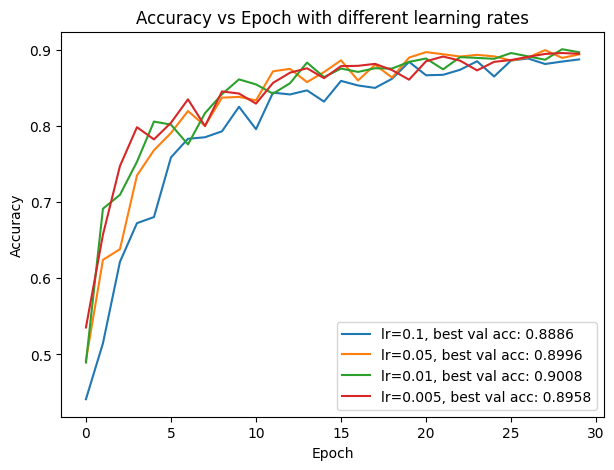

In [40]:
# print the best accuracy and its corresponding learning rate
print(f"Best accuracy: {np.max(lr_val_acc)} with learning rate: {l_LR[np.argmax(np.max(lr_val_acc, axis=1))]}")


plt.figure(figsize=(7, 5))
for i, lr in enumerate(l_LR):
    plt.plot(np.arange(EPOCHS), lr_val_acc[i], label=f'lr={lr}, best val acc: {np.max(lr_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different learning rates')
plt.legend()
plt.show()

#### Tune L2 Regularization

In [41]:
l_REG = [1e-3, 1e-4, 1e-5, 0]
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.05
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = ResNet20().to(device)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN(
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_reg_{reg}.pt"
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)

==> Current L2 regularization strength is: 0.001
==> Training starts!
EPOCH: 1, Training loss: 1.6720, Training accuracy: 0.3908
EPOCH: 1, Validation loss: 1.3819, Validation accuracy: 0.4994
EPOCH: 10, Training loss: 0.4703, Training accuracy: 0.8389
EPOCH: 10, Validation loss: 0.6509, Validation accuracy: 0.7864
EPOCH: 20, Training loss: 0.3779, Training accuracy: 0.8709
EPOCH: 20, Validation loss: 0.5714, Validation accuracy: 0.8150
EPOCH: 30, Training loss: 0.3502, Training accuracy: 0.8802
EPOCH: 30, Validation loss: 0.5193, Validation accuracy: 0.8312
==> Optimization finished! Best validation accuracy: 0.8472
==> Current L2 regularization strength is: 0.0001
==> Training starts!
EPOCH: 1, Training loss: 1.6474, Training accuracy: 0.3951
EPOCH: 1, Validation loss: 1.3963, Validation accuracy: 0.4862
EPOCH: 10, Training loss: 0.3903, Training accuracy: 0.8645
EPOCH: 10, Validation loss: 0.4967, Validation accuracy: 0.8368
EPOCH: 20, Training loss: 0.2040, Training accuracy: 0.9286

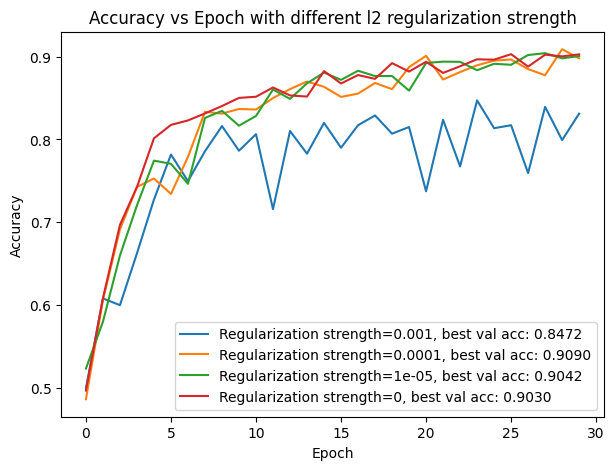

In [42]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()

#### Change to Swish

In [45]:
def swish(x):
    return x * torch.sigmoid(x)
class Residual_Block_swish(nn.Module):
    def __init__(self, input, output, stride, downsample):
        super(Residual_Block_swish, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.downsample = downsample

    def forward(self, x):
        x0 = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = swish(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample is not None:
            x0 = self.downsample(x0)
        output += x0
        output = swish(output)
        return output
    
class ResNet20_swish(nn.Module):
    def __init__(self, ):
        super(ResNet20_swish, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.Residual_Layer(input=64, output=64, stride=1)   # only the first layer's has stride=1 -- no downsample
        self.layer2 = self.Residual_Layer(input=64, output=128, stride=2)
        self.layer3 = self.Residual_Layer(input=128, output=256, stride=2)
        self.layer4 = self.Residual_Layer(input=256, output=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 10)


    def Residual_Layer(self, input, output, stride):
        if stride == 2:
            downsample = nn.Sequential(
                nn.Conv2d(input, output, kernel_size=1, stride=2, padding=0),
                nn.BatchNorm2d(output)
            )
        else:
            downsample = None
        layer = nn.Sequential(
            Residual_Block_swish(input, output, stride, downsample),
            Residual_Block_swish(output, output, 1, None)
        )
        return layer

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = swish(output)
        # output = self.maxpool(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

In [46]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-5

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_swish.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.5599, Training accuracy: 0.4247
EPOCH: 1, Validation loss: 1.3062, Validation accuracy: 0.5482
EPOCH: 10, Training loss: 0.3571, Training accuracy: 0.8780
EPOCH: 10, Validation loss: 0.4228, Validation accuracy: 0.8572
EPOCH: 20, Training loss: 0.1675, Training accuracy: 0.9416
EPOCH: 20, Validation loss: 0.3446, Validation accuracy: 0.8986
EPOCH: 30, Training loss: 0.0878, Training accuracy: 0.9688
EPOCH: 30, Validation loss: 0.3440, Validation accuracy: 0.9112
==> Optimization finished! Best validation accuracy: 0.9112


In [47]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-5

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 75
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_100epoch.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.6011, Training accuracy: 0.4058
EPOCH: 1, Validation loss: 1.3193, Validation accuracy: 0.5220
EPOCH: 10, Training loss: 0.3468, Training accuracy: 0.8792
EPOCH: 10, Validation loss: 0.3832, Validation accuracy: 0.8702
EPOCH: 20, Training loss: 0.1636, Training accuracy: 0.9419
EPOCH: 20, Validation loss: 0.3073, Validation accuracy: 0.9058
EPOCH: 30, Training loss: 0.0887, Training accuracy: 0.9686
EPOCH: 30, Validation loss: 0.3556, Validation accuracy: 0.9078
EPOCH: 40, Training loss: 0.0502, Training accuracy: 0.9817
EPOCH: 40, Validation loss: 0.3572, Validation accuracy: 0.9146
EPOCH: 50, Training loss: 0.0312, Training accuracy: 0.9887
EPOCH: 50, Validation loss: 0.3804, Validation accuracy: 0.9192
EPOCH: 60, Training loss: 0.0236, Training accuracy: 0.9914
EPOCH: 60, Validation loss: 0.3917, Validation accuracy: 0.9232
EPOCH: 70, Training loss: 0.0168, Training accuracy: 0.9939
EPOCH: 70, Validation loss: 0.4206, Validation accura

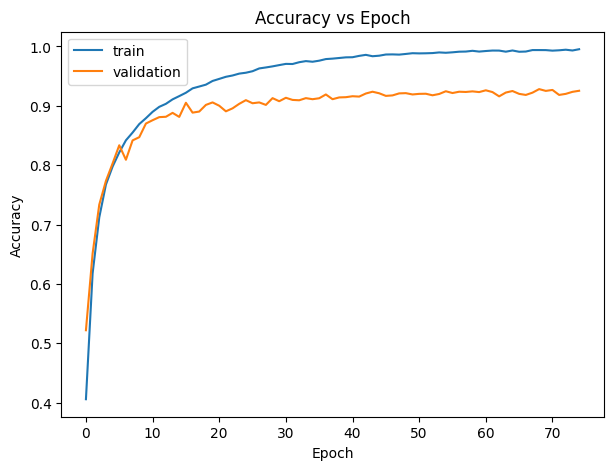

In [48]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(EPOCHS), l_train_acc, label='train')
plt.plot(np.arange(EPOCHS), l_val_acc, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

#### Accounting for overfitting 

In [49]:
l_REG = np.logspace(-4, -5, 4)
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.05
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 100
CHECKPOINT_FOLDER = "./saved_model"
# Weight decay
DECAY = 0.8
DECAY_EPOCH = 10

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = ResNet20_swish().to(device)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_WD(
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        DECAY_EPOCH,
        DECAY,
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_reg_{reg}.pt"
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)
    

==> Current L2 regularization strength is: 0.0001


NameError: name 'train_test_WD' is not defined

In [ ]:
print(f"Best accuracy: {np.max(l2_reg_val_acc)} with L2 regularization strength: {l_REG[np.argmax(np.max(l2_reg_val_acc, axis=1))]}")


plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg:.4e}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()